# Deletando os arquivos .xml das pastas

In [1]:
import os

folder1_path = "Dataset/miner_img"
folder2_path = "Dataset/rust_image"

def delete_xml_files(folder_path):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".xml"):
                file_path = os.path.join(root, file)
                os.remove(file_path)
                print(f"Arquivo {file} excluído com sucesso.")

delete_xml_files(folder1_path)
delete_xml_files(folder2_path)

# Importando bibliotecas

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Definir transformações para pré-processamento das imagens

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
data_dir = "Dataset"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dividindo as imagens entre treino e teste

In [5]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Criando o DataLoader para treinamento e teste

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Arquitetura da rede neural

In [7]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 56 * 56, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Inicializar o modelo

In [8]:
num_classes = len(dataset.classes)
model = CNNModel(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

# Treinando o modelo

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_dataloader)}")

Epoch [1/5], Loss: 1.316358466233526
Epoch [2/5], Loss: 0.4377025557415826
Epoch [3/5], Loss: 0.24157687383038656
Epoch [4/5], Loss: 0.19123624690941401
Epoch [5/5], Loss: 0.10695962208722319


In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy com as imagens de teste: {accuracy:.2f}%")

Accuracy com as imagens de teste: 92.66%


In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Lista para armazenar as imagens de teste classificadas corretamente e incorretamente

In [12]:
correct_images = []
incorrect_images = []

# Percorrendo as imagens de teste

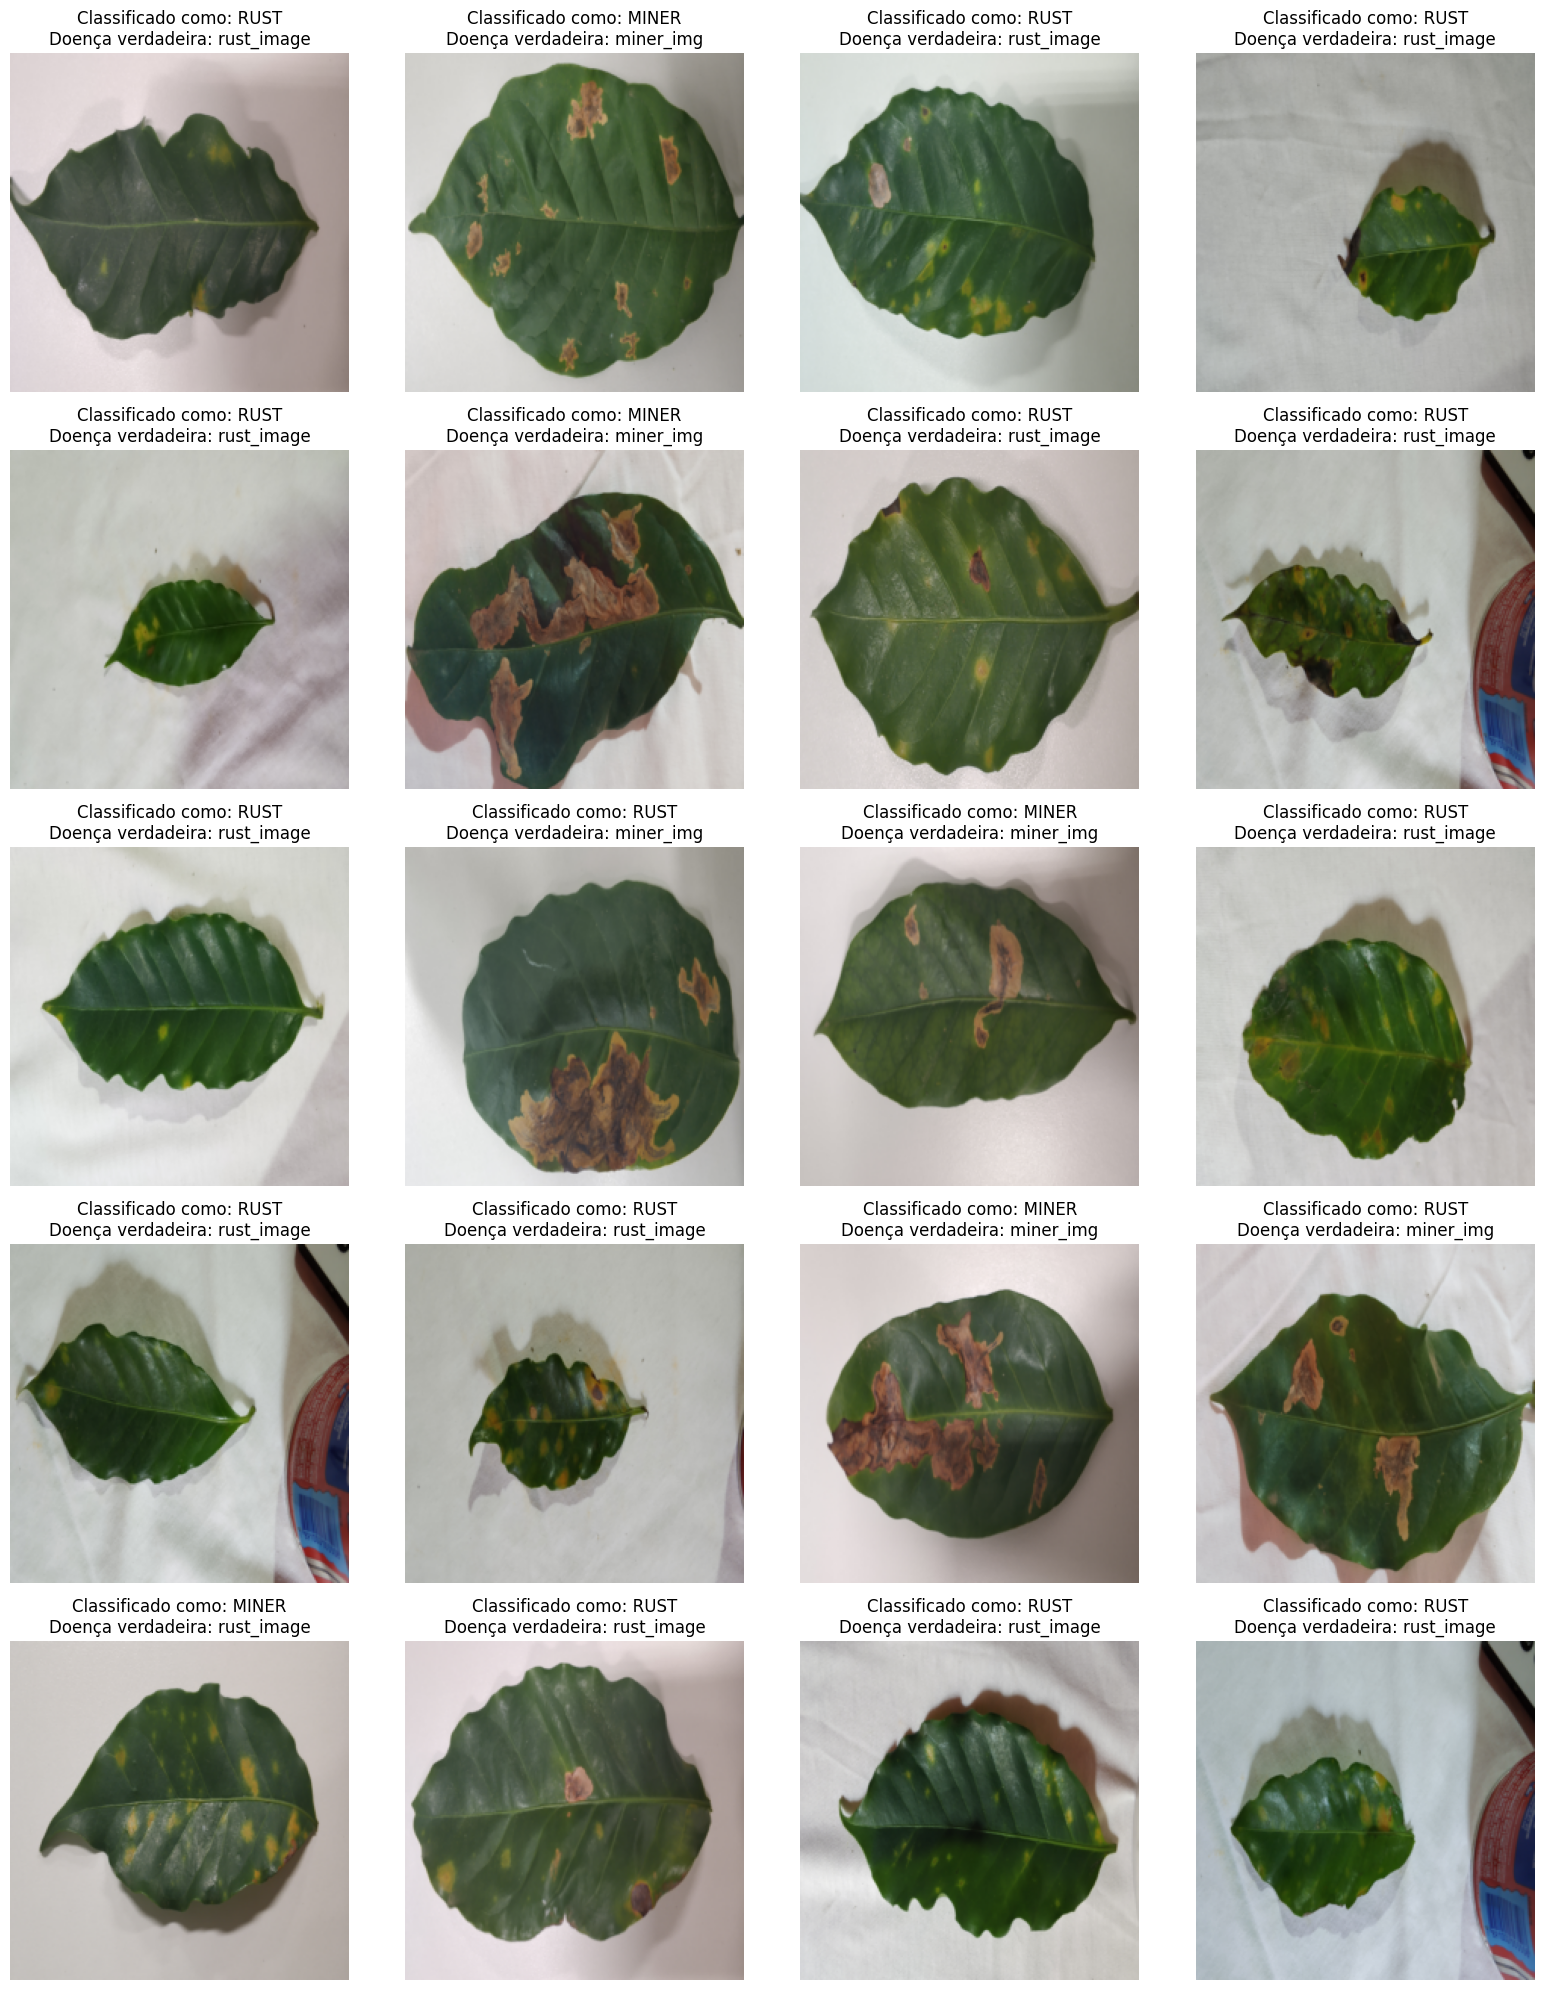

In [13]:
with torch.no_grad():
    fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(16, 20))
    axs = axs.ravel()

    for i, (inputs, labels) in enumerate(test_dataloader, 0):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

       
        inputs_np = inputs.cpu().numpy()
        predicted_np = predicted.cpu().numpy()

        for j in range(len(inputs)):
            if i * len(inputs) + j >= 20:
                break  # Limitar a 20 imagens
            title = "RUST" if predicted_np[j] == dataset.class_to_idx["rust_image"] else "MINER"
            axs[i * len(inputs) + j].imshow(np.transpose((inputs_np[j] * 0.5 + 0.5), (1, 2, 0))) 
            axs[i * len(inputs) + j].set_title(f"Classificado como: {title}\nDoença verdadeira: {dataset.classes[labels[j]]}")
            axs[i * len(inputs) + j].axis("off")

    plt.tight_layout()
    plt.show()

# Salvando o modelo de treinamento

In [14]:
model_path = 'Model/modelo.pth'

torch.save(model.state_dict(), model_path)